In [1]:
# Setup
import pandas as pd
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt 
import warnings
%matplotlib inline
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import folium
from scipy.interpolate import griddata
from numpy import linspace
import geojsoncontour
import plotly.graph_objects as go
import cufflinks
from plotly.offline import iplot, plot
import plotly.express as px
import plotly.io as pio
import base64
from folium import IFrame

EIGHT_HOURS = 28800 #in seconds

#Make the plots pretty
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='k'#'#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='k'#'#333F4B'
plt.rcParams['ytick.color']='k'#'#333F4B'
plt_txt = 10
plt.rcParams.update({'font.size': plt_txt})
blue = '#0091ea'
green = '#00c853'
orange = '#ffab00'

map_center = (37.993974, -98.927855) #lat lon of the center of the US

GET_URL = "https://api.is-conic.com/api/v0p1/debug/get_data"

# First, we'll load in data from our server and convert it into a pandas dataframe.

In [2]:
header = {"Content-Type": "application/json"}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    response = requests.request("GET", GET_URL, headers=header, verify=False)
if response.status_code != 200:
    raise Exception(response.status_code, response.text)
json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

# Next, we'll create a map image to show where all of our sensors are. 
## Click on one of the balloons to see more details

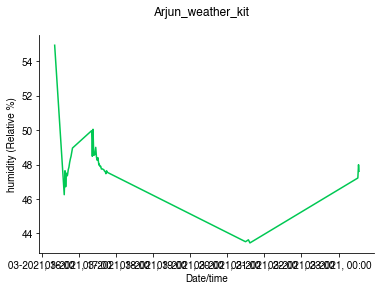

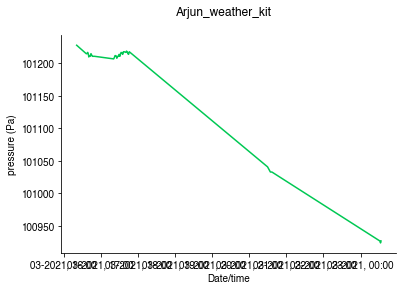

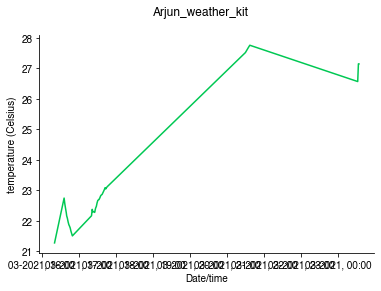

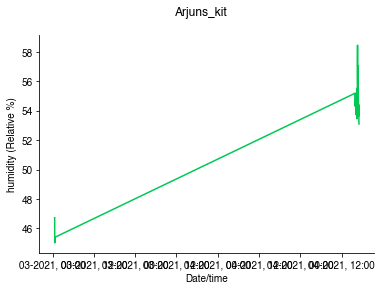

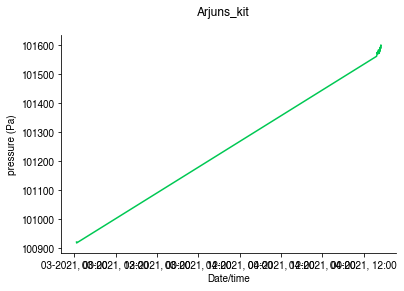

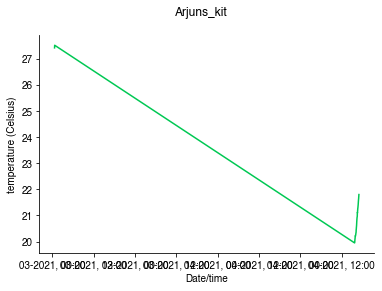

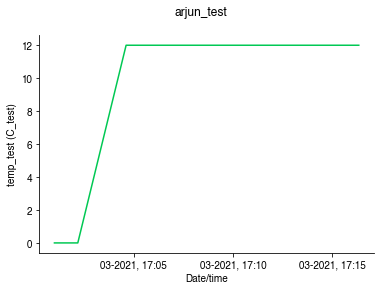

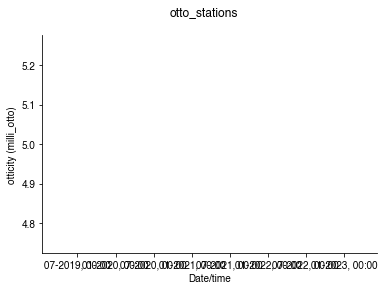

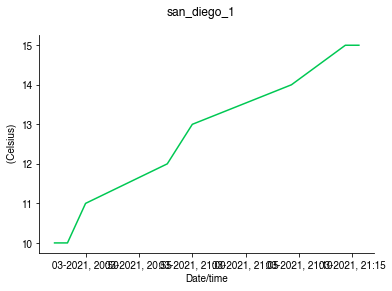

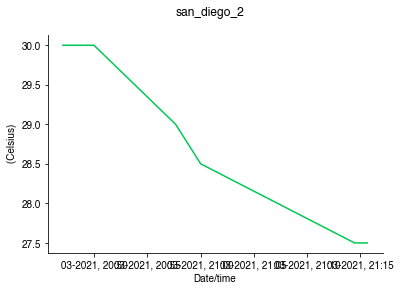

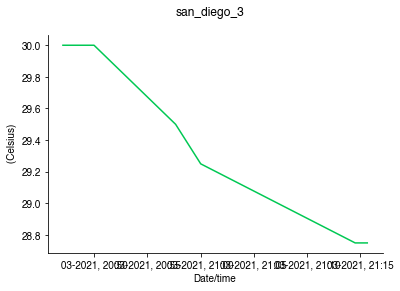

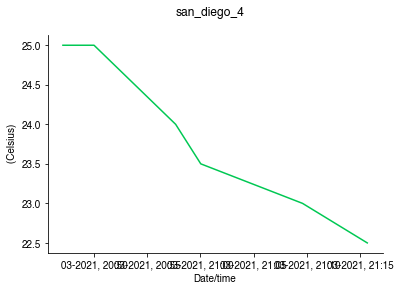

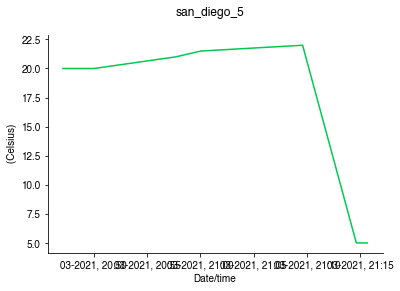

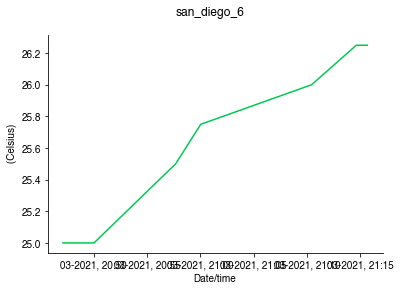

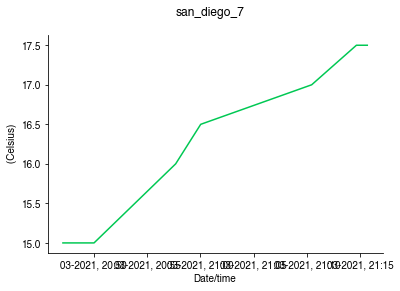

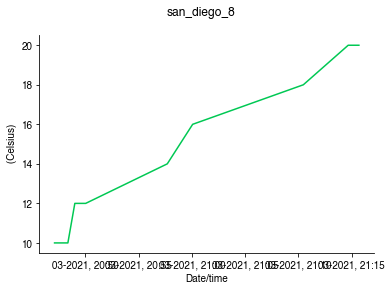

In [3]:
#make a folium map and the display format for dates
m = folium.Map(location=[map_center[0], map_center[1]], zoom_start=4, tiles="Stamen Terrain")
date_form = DateFormatter("%m-%Y, %H:%M")

#remove those with no location
map_df = df[(~df['lat'].isna()) & (~df['lon'].isna())]
#sort by receipt time, create a new time column that takes either receipt time or timestamp
map_df = map_df.sort_values('receipt_time', axis=0)
map_df['time'] = map_df['receipt_time'] #change this to use timestamp
map_df['time'] = map_df['time'].apply(lambda x: datetime.utcfromtimestamp(x))

#this html code gets piped into the folium popups. For each station,
#we're going to set ListOfImages to the graphs of the data from that station. 
#We use python string formatting (note the {}) to substitute in a list of images 
#in the format of JS code. 
#We switch images each time the button is clicked, keeping track of the current
#image with an index i.
html = """
<html>
<head>
<script> 

var ListOfImages = [{}];
var i = 0;

function changeImage(){{
    var img = document.getElementById("image");
    i = (i+1)%ListOfImages.length;
    img.src=ListOfImages[i];
    return false;
}}

</script>
</head>
<body>
    <img id="image" src="{}" />
    <button id="clickme" onclick="changeImage();">Next Graph</button>
</body>
</html>
""".format

#first, group by the set of stations, and iterate through them
map_df = map_df.groupby('key', as_index=False)
for station_name, grp in map_df:    
    #now, group this sensor by the measurement names - each of these gets its own graph
    grp_measurements = grp.groupby('measurement_name')
    image_strings = []
    for meas_name, subgrp in grp_measurements:
        #create the plot and save as a jpg as usual
        fig, ax = plt.subplots()
        ax.plot('time', 'value', color=green, data=subgrp)
        ax.set_ylabel("{} ({})".format(meas_name, subgrp['unit'].iloc[0]))
        ax.set_xlabel("Date/time")
        ax.xaxis.set_major_formatter(date_form)
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        fig.suptitle(station_name)
        figname = '{}_{}.jpg'.format(station_name, meas_name)
        plt.savefig("graph_images/" + figname, format="jpg", bbox_inches="tight", pad_inches=0.05)

        #convert the image to base64 encoding format, and put it into an HTML string
        encoded = base64.b64encode(open("graph_images/" + figname, 'rb').read())
        image_string = "data:image/png;base64,{}".format(encoded.decode('UTF-8'))
        image_strings.append(image_string)
    
    #We want this to be a string that goes in the JS code, so format it as '"A", "B", "C"'
    #note that the brackets are already supplied in the JS code so we don't need them here
    list_of_strings = '"' + '", "'.join(image_strings) + '"'
    #the second argument is which of the graphs gets displayed first
    iframe = IFrame(html(list_of_strings, image_strings[0]), width=400, height=350)
    popup = folium.Popup(iframe, max_width=400)

    folium.Marker([grp.iloc[-1]['lat'], grp.iloc[-1]['lon']], \
                  popup=popup, tooltip=station_name).add_to(m)

m

# Now, we're going to make a heatmap from this data 

In [121]:
#this code is from https://towardsdatascience.com/visualizing-spatial-data-with-geojson-heatmaps-1fbe2063ab86

#number of groups to use for the heatmap; higher gives smoother color gradients
n_grades = 50
type_selected = "Celsius"

#we're going to filter the heatmap by san diego for now
heatmap_df = df[df['key'].str.contains("san_diego")]

heatmap_df = heatmap_df[heatmap_df['unit'] == type_selected]
heatmap_df['receipt_time'] = heatmap_df['receipt_time'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))

'temp-plot.html'

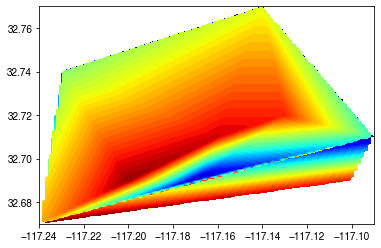

In [122]:
#in order to map we need 2 items:
# 1. a pandas "contour dataframe" where each row is a location id, and a color value to use
# 2. a geojson containing geometries and location ids
# to use a slider we just need multiple of these, one for each position of the slider

#transform into an interpolated array to improve coverage of the map
heatmap_center = heatmap_df['lat'].mean(), heatmap_df['lon'].mean()

def make_contour_and_geojson(df):
    """
    Given a dataframe containing value, lat, and lon, linearly interpolate the points
    to get a contour. Then create a geojson dictionary based on that contour, and 
    a pandas df containing both color values and location ids to tie the df to the geojson.
    """
    z = df['value'].to_numpy()
    y = df['lat'].to_numpy()
    x = df['lon'].to_numpy()
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    
    #linear interpolation. x, y, z are the true values; xi, yi are the grid to interpolate on
    zi = griddata((x, y), z, (xi, yi), method='linear')

    #infer the min_value and step size from n_grades
    #min value must be < z.min but min_value + step_size must be greater!
    min_value = z.min() - np.nextafter(0, 1)
    max_value = z.max()
    step_size = (max_value - min_value) / n_grades
    max_value += step_size
    
    #Creating contour plot and turn it into the geojson dict
    cs = plt.contourf(xi,yi,zi,np.arange(min_value, max_value, step_size),
                      cmap=plt.cm.jet)
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=cs,
    )
    heat_geojson=eval(geojson)

    # For each region (aka "feature"), set its ID equal to i.
    # This new array will map ID i to the lower bound of color bucket the ID belongs to
    arr_temp=np.ones([len(heat_geojson["features"]),2])
    for i in range(len(heat_geojson["features"])):
        heat_geojson["features"][i]["id"] = i
        arr_temp[i,0]=i
        bounds = heat_geojson["features"][i]["properties"]["title"]
        arr_temp[i,1] = bounds.split("-")[0]
    df_contour = pd.DataFrame(arr_temp, columns=["id","title"])

    return df_contour, heat_geojson

#now create both the data and slider. 
# the data should be a list where each is a choroplethmapbox with the relevant data
# slider mainly contains a list of step dicts mapping args to a boolean list
steps = []
data = []
heatmap_df['hm'] = heatmap_df['receipt_time'].apply(lambda x: x.minute + 60*x.hour)
grouped = heatmap_df.groupby("hm", as_index=False)
i = 0
for name, grp in grouped:
    step = dict(method='restyle', args=['visible', [False] * len(grouped)], label=name)
    step['args'][1][i] = True
    steps.append(step)
    df_contour, heat_geojson = make_contour_and_geojson(grp)
    trace = go.Choroplethmapbox(geojson=heat_geojson,
                            locations=df_contour["id"],
                            z=df_contour["title"],
                            colorscale="jet",  
                            marker_line_width=0,
                            marker={'opacity': 0.5})
    data.append(trace)
    i+=1

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = go.Layout(
    title="{} Data".format(type_selected), title_x=0.4,
    height = 800,
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
    mapbox = dict(center = {'lat': heatmap_center[0], 'lon': heatmap_center[1]},
    zoom = 11, style = "carto-positron"), sliders=sliders)

figure={'data': data, 'layout': layout}

plot(figure)